# Data Exploration

In this notebook describe your data exploration steps.

## Install dependencies

In [1]:
%pip install -r requirements.txt
import requests
import geopandas as gpd
from xml.etree import ElementTree as ET
import io
import os
from rtree import index
import json
import sqlite3
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import folium


Note: you may need to restart the kernel to use updated packages.


### Refactoring
In order to keep this notebook short and explorative we refactor the code into pipeline.py.
From here on out we assume data/streets.geojson and data/trees.geojson to exist and data/pipeline.py to have been run successfully.

In [183]:
# Load data

def try_load(df_name) -> gpd.GeoDataFrame:
    if os.path.exists(f"{df_name}.pkl"):
        return pd.read_pickle(f"{df_name}.pkl")
    elif os.path.exists(f"data/{df_name}.geojson"):
        return gpd.read_file(f"data/{df_name}.geojson")
    else:
        raise Exception(f"{df_name} not found, please run data/pipeline.py")

trees = try_load("trees")
trees.to_pickle("trees.pkl")

streets = try_load("streets")
streets.to_pickle("streets.pkl")

speed_limits = try_load("speed_limits")
speed_limits.to_pickle("speed_limits.pkl")

merged_data = try_load("merged_data")
merged_data.to_pickle("merged_data.pkl")


In [131]:
merged_data['strassenklasse'].value_counts()

strassenklasse
G    4638568
B     616077
A       4934
Name: count, dtype: int64

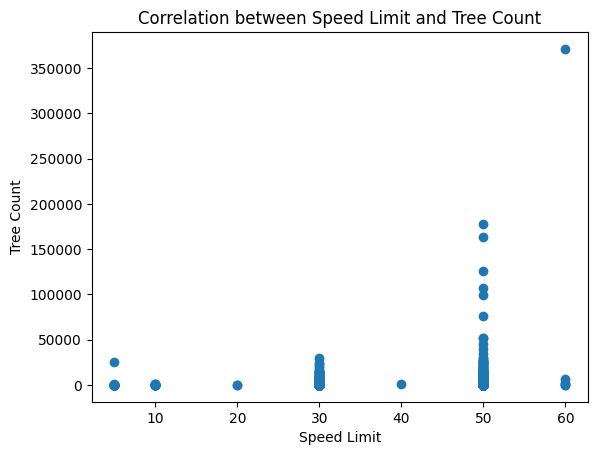

In [135]:
import matplotlib.pyplot as plt

def plot_speed_to_tree_count(df):
    plt.scatter(df['speed_limit'], df['tree_count'])
    plt.xlabel('Speed Limit')
    plt.ylabel('Tree Count')
    plt.title('Correlation between Speed Limit and Tree Count')
    plt.show()

# ensure that speed_limit is a float
merged_data['speed_limit'] = merged_data['speed_limit'].astype(float)
# aggregate data by street name
aggregated_data = merged_data.groupby('strassenname').agg({'speed_limit': 'first', 'gattung_deutsch': 'count'}).reset_index()
aggregated_data.rename(columns={'gattung_deutsch': 'tree_count'}, inplace=True)


plot_speed_to_tree_count(aggregated_data)

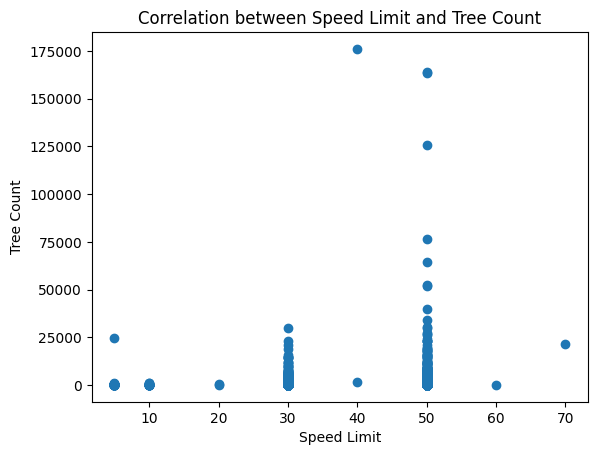

In [137]:
# Only consider Gemeindestraßen
inner_city_data = merged_data.copy()[merged_data['strassenklasse'] == 'G']

# aggregate data by street name
aggregated_inner_data = inner_city_data.groupby('strassenname').agg({'speed_limit': 'first', 'gattung_deutsch': 'count'}).reset_index()
aggregated_inner_data.rename(columns={'gattung_deutsch': 'tree_count'}, inplace=True)

plot_speed_to_tree_count(aggregated_inner_data)

In [148]:
inner_city_data.head()

,id_x,strassenname,strassenklasse,elem_nr,speed_limit,id_y,strname,gattung,gattung_deutsch,geometry
0,8,Aalemannufer,G,34610003_34610004.01,50.0,00008100:00123c8e,Aalemannufer,ACER,AHORN,"LINESTRING (13.21996 52.57307, 13.22225 52.573..."
1,8,Aalemannufer,G,34610003_34610004.01,50.0,00008100:00123c8f,Aalemannufer,ACER,AHORN,"LINESTRING (13.21996 52.57307, 13.22225 52.573..."
2,8,Aalemannufer,G,34610003_34610004.01,50.0,00008100:00123c90,Aalemannufer,ACER,AHORN,"LINESTRING (13.21996 52.57307, 13.22225 52.573..."
3,8,Aalemannufer,G,34610003_34610004.01,50.0,00008100:00123c92,Aalemannufer,ACER,AHORN,"LINESTRING (13.21996 52.57307, 13.22225 52.573..."
4,8,Aalemannufer,G,34610003_34610004.01,50.0,00008100:00123c93,Aalemannufer,ACER,AHORN,"LINESTRING (13.21996 52.57307, 13.22225 52.573..."


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


df = inner_city_data.copy()

df_grouped = df.groupby(['speed_limit']).size().reset_index(name='tree_count')


# Pivot the DataFrame to get tree types as columns
df_pivot = df.pivot_table(index='speed_limit', columns='gattung_deutsch', aggfunc='size', fill_value=0)
 
df_merged = df_grouped.merge(df_pivot, on='speed_limit')

correlation = df_merged.corr()
speed_limit_corr = correlation[['speed_limit']]


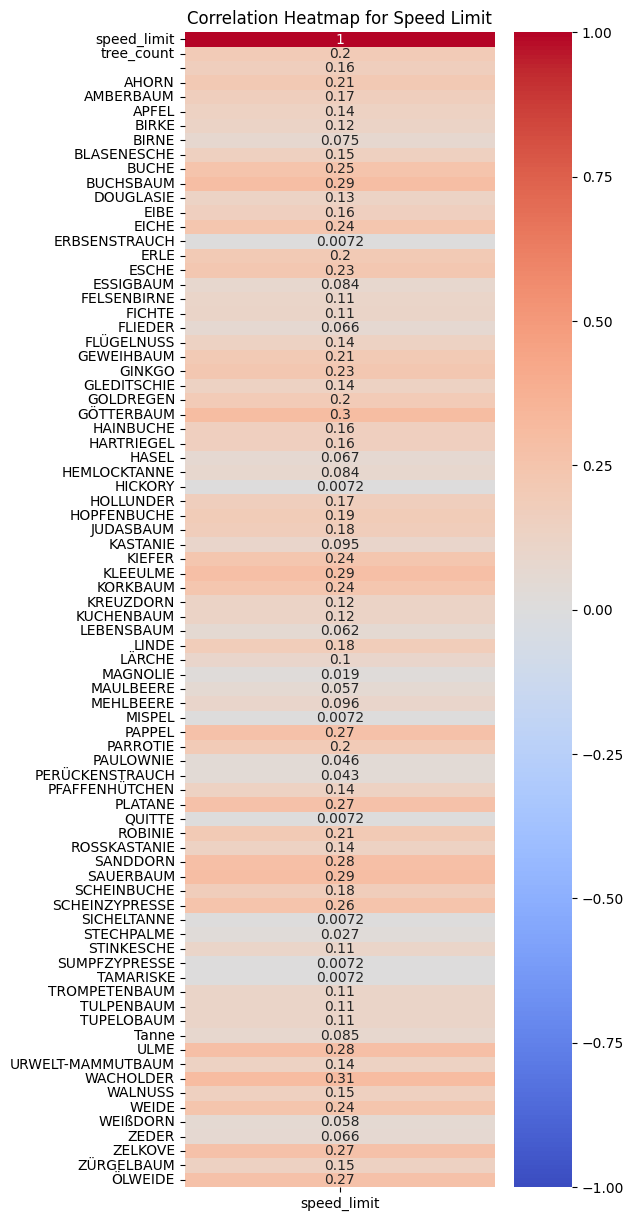

In [175]:
plt.figure(figsize=(5, 15))  # Specify the size of your heatmap
sns.heatmap(speed_limit_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Speed Limit")
plt.show()